In [1]:
from aicsimageio.readers import CziReader
from skimage.filters import threshold_otsu
from skimage.exposure import adjust_gamma, is_low_contrast
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import napari
import numpy as np
import numpy.ma as ma
import subprocess
import os, sys

In [2]:
%gui qt

In [3]:
# Path to CZI File
FILE_PATH = "/mnt/5404b8a5-71b7-4464-9a1e-b40cd26fac58/Data_Drive/Wissam/Dendrite_Movies/Cell_351-WT-Green_Channel_Just_ECF_at_0_minutes_DIV19.czi"

# Cell's ID
CELL_ID = "Cell_351-WT"

# Path to ilastik launch script
ILASTIK_LOC = '/home/peter/Applications/ilastik-1.3.3post3-Linux/run_ilastik.sh'

#  Path to ilastik classifier project
ILASTIK_PRO = 'neuron_classifier.ilp'

SEG_DIC = {0:"Background",
          1:"Soma",
          2:"Dendrites"
         }


In [4]:
Czi_File = CziReader(FILE_PATH)


In [5]:
movie = Czi_File.data[0,:,0,:,:]


In [6]:
max_project = np.max(movie, axis=0)
brighter = adjust_gamma(max_project, gamma=.25)
OUTPUT = '%s_Brighter.npy'%(CELL_ID)
np.save(OUTPUT, brighter/brighter.max())


In [7]:
launch_args = [ILASTIK_LOC,
               '--headless',
               '--project='+ILASTIK_PRO,
               '--export_source=probabilities',
               OUTPUT]
subprocess.run(launch_args)

CompletedProcess(args=['/home/peter/Applications/ilastik-1.3.3post3-Linux/run_ilastik.sh', '--headless', '--project=neuron_classifier.ilp', '--export_source=probabilities', 'Cell_351-WT_Brighter.npy'], returncode=0)

In [8]:
#!bash $ILASTIK_LOC --headless --project=$ILASTIK_PRO --export_source="Probabilities" $OUTPUT

In [9]:
pixel_classifier = h5py.File('Cell_351-WT_Brighter_Probabilities.h5')
classes = pixel_classifier['exported_data']


/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


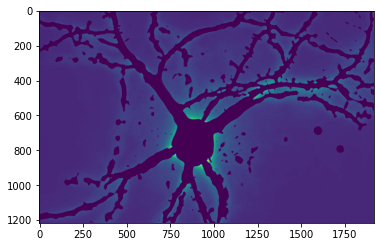

72.24414


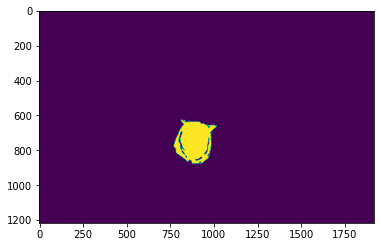

67.935


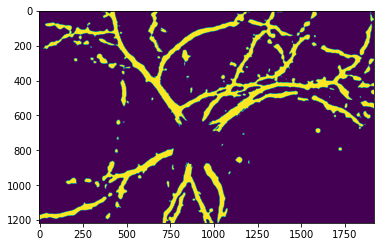

In [10]:

labels = np.zeros(max_project.shape)
label = 0

for i in range(classes.shape[2]):
    class_mask = classes[:,:,i].copy()
    class_mask[class_mask<.75]=0
    test= max_project*class_mask
    if i is not 0:
        test = brighter * class_mask
        threshold =threshold_otsu(test)
        print(threshold)
        test[test<threshold]=0
        test[test>threshold]=1
        labels[test>0]=label
    label+=1
    plt.imshow(test)
    plt.show()

0
1
2


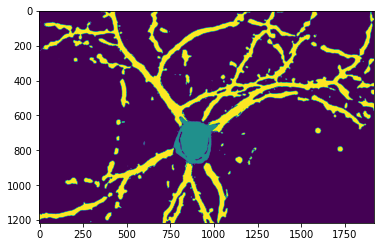

In [11]:
# Generates ROIs
# 0  - Background
# 1 - Soma
# 2 - Dendrites
labels = np.zeros(max_project.shape)
label = 0
for i in range(classes.shape[2]):
    print(i)
    labels[classes[:,:,i]>.60]=label
    label+=1
plt.imshow(labels)

In [12]:
# Clean up stuff from memory
del test
del classes
del pixel_classifier

In [13]:
#Labels can be edited in the Napari window
viewer = napari.view_image(movie, name='movie')
viewer.add_labels(labels, name='Segments')

<Labels layer 'Segments' at 0x7f5f605345c0>

In [ ]:
np.save('labels_'+OUTPUT)


In [ ]:
for i in (np.unique(labels)):
    if i !=0:
        trace_movie = movie.copy()
        trace_movie = np.broadcast_to(labels==i, trace_movie.shape)
        trace_movie.setflags(write=1)
        trace_movie[trace_movie !=0]=1
        trace_movie = movie*trace_movie

        mask_arr = trace_movie==0

        mx = ma.masked_array(trace_movie, mask=mask_arr)
        mean = mx.mean(axis=(1,2))
        print("Ca2+ Trace for the %s" %SEG_DIC[i])
        plt.plot(mean)
        plt.show()
      
        np.savetxt("{0}_{1}.csv".format(CELL_ID, SEG_DIC[i]), mean, delimiter="," )
        del trace_movie
        del mask_arr
        del mx
        del mean 
        